In [1]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

TRAIN_DATA = MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
TEST_DATA = MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

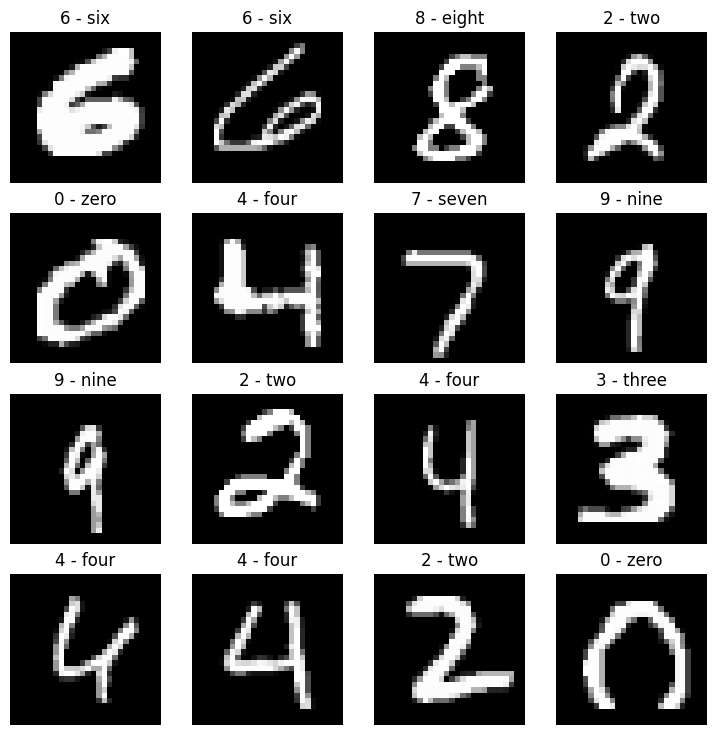

In [2]:
from matplotlib import pyplot as plt
import torch

class_names = TRAIN_DATA.classes

torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(TRAIN_DATA), size=[1]).item()
    img, label = TRAIN_DATA[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [3]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
TRAIN_DATALOADER = DataLoader(
    dataset=TRAIN_DATA,
    batch_size=BATCH_SIZE,
    shuffle=True
)
TEST_DATALOADER = DataLoader(
    dataset=TEST_DATA,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [4]:
from torch import nn


class MNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


In [5]:
mnist_model_0 = MNISTModelV0(1, 10, len(class_names))

In [6]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mnist_model_0.parameters(), lr=0.1)

In [7]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
    """performs a training with model trying to learn on data_loader"""
    train_loss, train_acc = 0, 0
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"train loss: {train_loss:.5f}, train acc: {train_acc:.2f}%")

In [8]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):
    # TESTING
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"test loss: {test_loss:.5f}, test acc: {test_acc:.2f}%")

In [9]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

torch.manual_seed(42)
start_time = timer()
# train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"epoch: {epoch}")
    train_step(model=mnist_model_0, data_loader=TRAIN_DATALOADER, loss_fn=loss_fn, optimizer=optimizer,
               accuracy_fn=accuracy_fn)
    test_step(model=mnist_model_0, data_loader=TEST_DATALOADER, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
end_time = timer()
mnist_model_0_total_time = end_time - start_time
print(f"trained for {mnist_model_0_total_time} seconds")

C:\Users\lhuen\PycharmProjects\MNIST-SiameseNetwork\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0
train loss: 0.47413, train acc: 83.18%


 33%|███▎      | 1/3 [00:23<00:46, 23.30s/it]

test loss: 0.08215, test acc: 97.38%
epoch: 1
train loss: 0.07879, train acc: 97.52%


 67%|██████▋   | 2/3 [00:47<00:23, 23.57s/it]

test loss: 0.05470, test acc: 98.14%
epoch: 2
train loss: 0.06287, train acc: 98.01%


100%|██████████| 3/3 [01:10<00:00, 23.35s/it]

test loss: 0.05601, test acc: 98.22%
trained for 70.04946039995411 seconds


In [20]:
def make_predictions(model: torch.nn.Module, data: list):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0)
            pred_logits = model(sample)
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

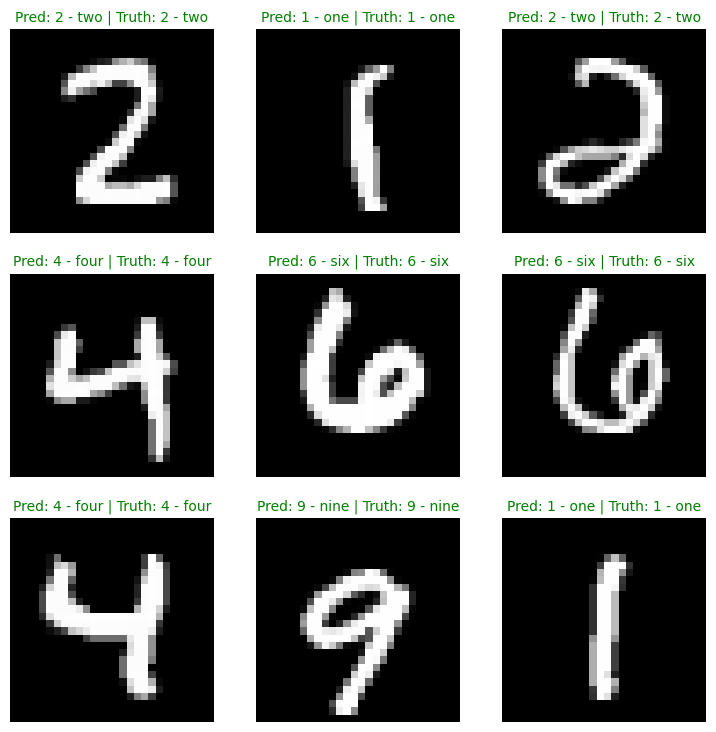

In [22]:
import random


def visualize_preds(model:nn.Module, test_data):
    random.seed(42)
    test_samples = []
    test_labels = []
    for sample, label in random.sample(list(test_data), k=9):
        test_samples.append(sample)
        test_labels.append(label)
    pred_probs = make_predictions(model, test_samples)
    pred_classes = pred_probs.argmax(dim=1)
    plt.figure(figsize=(9, 9))
    nrows = 3
    ncols = 3
    for i, sample in enumerate(test_samples):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(sample.squeeze(), cmap="gray")
        pred_label = class_names[pred_classes[i]]
        truth_label = class_names[test_labels[i]]
        title_text = f"Pred: {pred_label} | Truth: {truth_label}"
        # check for equality
        if pred_label == truth_label:
            plt.title(title_text, fontsize=10, c="g")  # green if pred true
        else:
            plt.title(title_text, fontsize=10, c="r")  # red if pred false
        plt.axis(False)
''

visualize_preds(model=mnist_model_0, test_data=TEST_DATA)